In [1]:
import sys
sys.path.append('../data')
sys.path.append('../data/low')
sys.path.append('../data/mid')
sys.path.append('../Librerias')

import dataset as ds
import utils
import caract as dc


import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import seaborn as sns

from os import listdir
from os.path import isfile, join
from fitter import Fitter, get_common_distributions, get_distributions
import scipy.stats as stats

import scipy.signal as signal


sns.set_style("darkgrid")

In [2]:
#fpath = "/Users/granosftp/Documents/GitHub/Tesis/data/high/"
fpath =  "/Users/consu/OneDrive/Documentos/GitHub/Tesis/data/low/"
onlyfiles = [f for f in listdir(fpath) if isfile(join(fpath, f))]

cutoff = [8/1000, 11/1000]


## **low frames**

In [3]:
#load data
frames = []
for fname in onlyfiles:
    if fname.endswith(".mat"):
        set =  ds.MatFileToDataFrame(fpath, fname)
        df = set.get_dataframe(cutoff)
        frames.append(df)
        print(fname)

file10_080124.mat
file11_080124.mat
file12_080124.mat
file13_080124.mat
file15_080124.mat
file16_080124.mat
file17_080124.mat
file18_080124.mat
file1_050124.mat
file1_080124.mat
file2_050124.mat
file3_080124.mat
file7_080124.mat
file8_080124.mat
file9_080124.mat
low1_100124.mat
low2_100124.mat
low3_100124.mat
low5_100124.mat


In [4]:
defectos_frames = []
taus = []
for i, df in enumerate(frames):
    aux = dc.CaractDefect(df)
    defectos_frames.append(aux)
    taus.append(aux.get_tau()[1])
    sys.stdout.write(str(i) + '\r')

In [5]:
hilbert_frames = []
for i, df in enumerate(defectos_frames):
    aux, _ = df.get_hilbert()
    hilbert_frames.append(aux)
    sys.stdout.write(str(i) + '\r')

**dataframe con defectos**

In [6]:
# dataframe con defectos
frames_cd = []

for i in range(len(frames)):
    frames_cd.append(pd.merge(frames[i], hilbert_frames[i], on='Hilbert Transform', how='outer'))

frames_cd[0]

,Original Signal,Signal - Mean,Filtered Signal,Hilbert Transform,Amplitude,Instantaneous Phase,Gradient Phase
0,0.076967,-0.041045,-0.005045,-0.005045+0.003866j,0.006356,2.487745,-0.050221
1,0.076638,-0.041374,-0.004841,-0.004841+0.000279j,0.004849,3.083952,-0.023636
2,0.073022,-0.044991,-0.004633,-0.004633+0.000083j,0.004634,3.123610,0.001438
3,0.073022,-0.044991,-0.004421,-0.004421-0.001203j,0.004582,3.407171,0.023619
4,0.071378,-0.046635,-0.004205,-0.004205-0.001356j,0.004419,3.453607,0.041826
...,...,...,...,...,...,...,...
599995,0.176268,0.058256,0.000015,0.000015+0.000493j,0.000493,30135.697377,-0.289769
599996,0.177254,0.059242,0.000033,0.000033+0.000343j,0.000345,30135.630801,-0.245612
599997,0.179227,0.061215,0.000050,0.000050+0.001284j,0.001285,30135.688260,-0.187389
599998,0.179885,0.061872,0.000066,0.000066+0.001095j,0.001097,30135.667052,-0.118399


**dataframe sin defectos**

In [7]:
signal_nd = []
hilbert_nd = []
for i, elem in enumerate(defectos_frames):
    x, y = elem.get_no_defectos()
    signal_nd.append(x)
    hilbert_nd.append(y)
    sys.stdout.write(str(i) + '\r')

In [8]:
display(signal_nd[0].head())
display(hilbert_nd[0].head())

,Original Signal,Signal - Mean,Filtered Signal,Hilbert Transform
0,0.076967,-0.041045,-0.005045,-0.005045+0.003866j
1,0.076638,-0.041374,-0.004841,-0.004841+0.000279j
2,0.073022,-0.044991,-0.004633,-0.004633+0.000083j
3,0.073022,-0.044991,-0.004421,-0.004421-0.001203j
4,0.071378,-0.046635,-0.004205,-0.004205-0.001356j


,Hilbert Transform,Amplitude,Instantaneous Phase,Gradient Phase
0,-0.005045+0.003866j,0.006356,2.487745,-0.050221
1,-0.004841+0.000279j,0.004849,3.083952,-0.023636
2,-0.004633+0.000083j,0.004634,3.123610,0.001438
3,-0.004421-0.001203j,0.004582,3.407171,0.023619
4,-0.004205-0.001356j,0.004419,3.453607,0.041826


**indices de los defectos**

In [9]:
# obtención de los indices de los defectos

defectos_indices = []
for elem in defectos_frames:
    indices, _ = elem.get_defectos()
    defectos_indices.append(indices)


In [10]:
# arreglo con los DataFrame que tienen los inicios, finales e indice tau de los defectos

tau_indices = []
for elem in defectos_frames:
    tau_indices.append(elem.get_tau_indices())


In [11]:
# arreglo con el inicio y final de los defectos
indices_defectos = []
for elem in tau_indices:
    x = elem[['start', 'end']]
    indices_defectos.append(x.values)

In [12]:
len(indices_defectos)

19

**funciones para ventanas**

In [13]:
def create_windows(df, size = 4000, overlap = 500):
    num_windows = (len(df) - size) // (size - overlap) + 1
    windows = []
    for i in range(num_windows):
        start = i * (size - overlap)
        end = start + size
        window = df.iloc[start:end]
        windows.append(window)
    return windows

def find_windows(start_end_defectos, windows):
    result = []
    for elem in start_end_defectos:
        for i, window in enumerate(windows):
            if elem[0] >= window.index[0] and elem[1] <= window.index[-1]:
                result.append(i)
                break
    return result

**array con ventanas**

In [14]:
# creo ventanas con 2000 elementos un overlap del 5%
all_windows = []
for elem in frames_cd:
    x = create_windows(elem, 2000, 100)
    all_windows.append(x)

In [15]:
# recupero los indices de las ventanas con defectos
indices_cd = []
for array, indices in zip(all_windows, indices_defectos):
    x = find_windows(indices, array)
    indices_cd.append(x)

unique_indices = []
for elem in indices_cd:
    x = np.unique(elem)
    unique_indices.append(x)


In [16]:
# elimino las ventanas con defectos
windows_sd = []
for windows, indx in zip(all_windows, unique_indices):
    x = [i for j, i in enumerate(windows) if j not in indx]
    windows_sd.append(x)

## **psd (fft con numpy)**
Se toman los psd y dft de las ventanas, se promedian y se comparan con las de la señal completa con los defectos.

In [17]:
def ffts(signal, fs=1000):
    n = len(signal)
    T = 1/fs
    yf = np.fft.fft(signal)
    freqs = np.fft.fftfreq(n, d = T)
    psd = np.abs(yf)**2
    return freqs, psd

In [18]:
# todos los valores

psd_all = []
psd_all_mean = []

psd_amp_all = []
psd_amp_all_mean = []

frequency = []

for elem in all_windows:
    psd_aux = []
    f_aux = []
    amp_aux = []
    for window in elem:
        x = window['Filtered Signal'].values
        y = window['Amplitude'].values

        f, xx = ffts(x)
        _, yy = ffts(y)

        psd_aux.append(xx)
        amp_aux.append(yy)
        f_aux.append(f)

    mean_psd = np.mean(psd_aux, axis = 0)
    mean_amp = np.mean(amp_aux, axis = 0)

    psd_all.append(psd_aux)
    psd_all_mean.append(mean_psd)
    psd_amp_all.append(amp_aux)
    psd_amp_all_mean.append(mean_amp)

    frequency.append(np.mean(f_aux, axis=0))

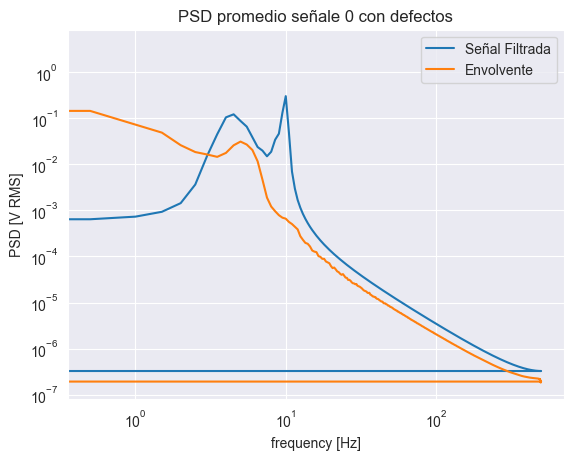

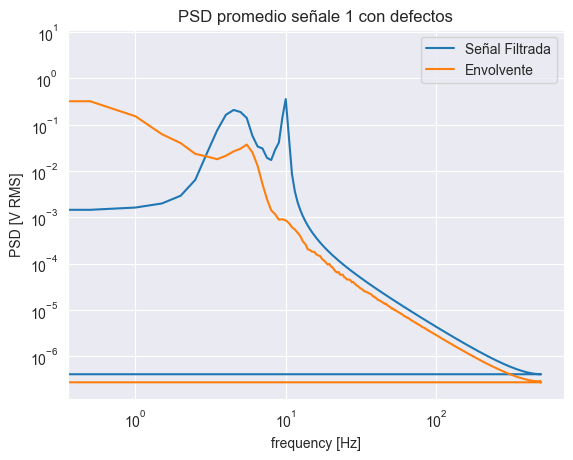

In [19]:
for i, (psd, amp ,freq) in enumerate(zip(psd_all_mean[:2], psd_amp_all_mean[:2],frequency[:2])):
    plt.loglog(freq,psd, label = 'Señal Filtrada')
    plt.loglog(freq, amp, label = 'Envolvente')
    plt.xlabel('frequency [Hz]')
    plt.ylabel('PSD [V RMS]')
    plt.title(f'PSD promedio señale {i} con defectos')
    plt.legend()
    plt.show()

In [20]:
# valores sin defectos
psd_signal = []
psd_signal_mean = []

psd_amp = []
psd_amp_mean = []

freqs = []

for elem in windows_sd:
    psd_aux = []
    freqs_aux = []
    amp_aux = []
    for window in elem:
        x = window['Filtered Signal'].values
        y = window['Amplitude'].values

        f, xx = ffts(x)
        _, yy = ffts(y)

        psd_aux.append(xx)
        amp_aux.append(yy)
        freqs_aux.append(f)

    mean_psd = np.mean(psd_aux, axis = 0)
    mean_amp = np.mean(amp_aux, axis = 0)

    psd_signal.append(psd_aux)
    psd_signal_mean.append(mean_psd)
    psd_amp.append(amp_aux)
    psd_amp_mean.append(mean_amp)

    freqs.append(np.mean(freqs_aux, axis=0))


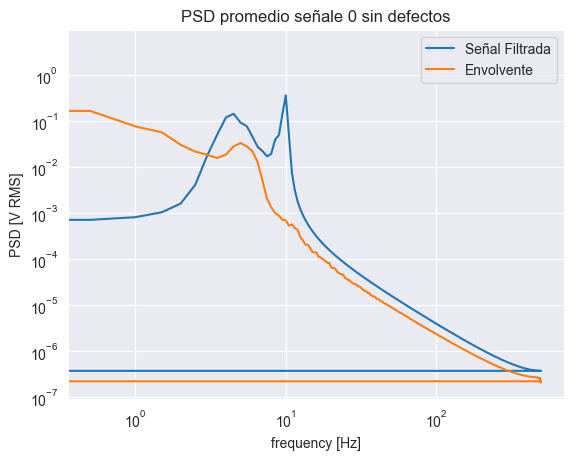

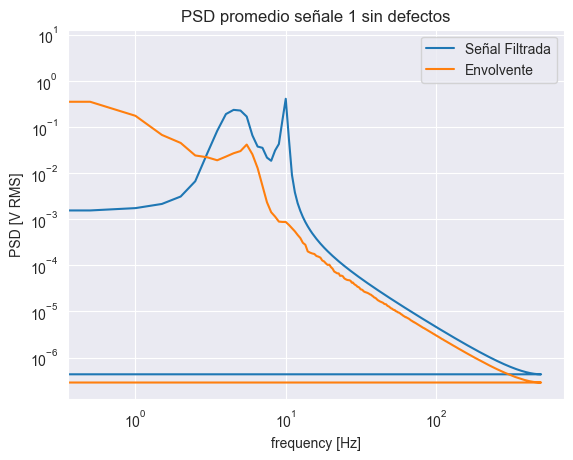

In [21]:

for i, (psd, amp ,freq) in enumerate(zip(psd_signal_mean[:2], psd_amp_mean[:2],freqs[:2])):
    plt.loglog(freq,psd, label = 'Señal Filtrada')
    plt.loglog(freq, amp, label = 'Envolvente')
    plt.xlabel('frequency [Hz]')
    plt.ylabel('PSD [V RMS]')
    plt.title(f'PSD promedio señale {i} sin defectos')
    plt.legend()
    plt.show()


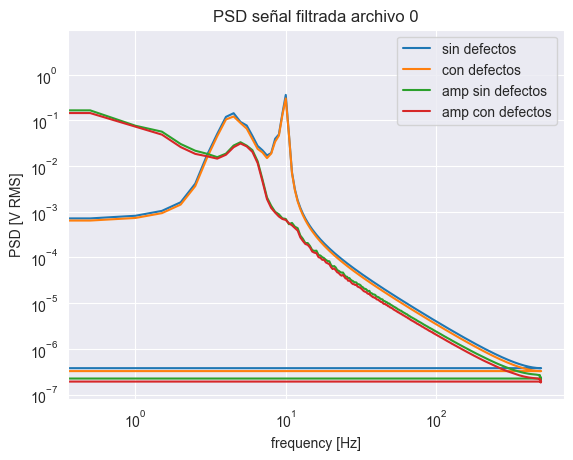

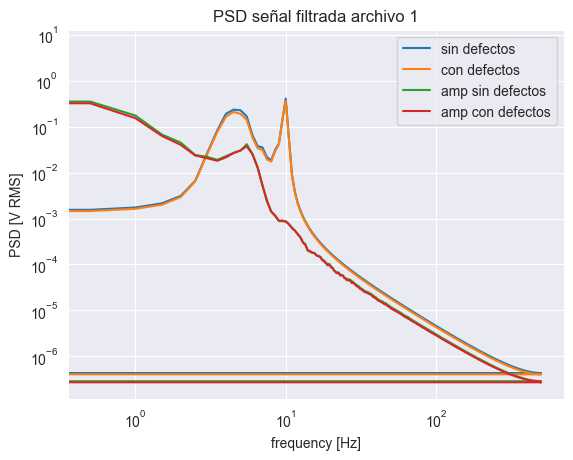

In [22]:
iterables = zip(psd_signal_mean[:2], psd_all_mean[:2], psd_amp_mean[:2], psd_amp_all_mean[:2],freqs[:2], frequency[:2])



for i, (psd_mean, psd_all, amp_mean, amp_all, freq1, freq2) in enumerate(iterables):
    plt.figure
    plt.loglog(freq1,psd_mean, label = 'sin defectos')
    plt.loglog(freq2, psd_all, label = 'con defectos')
    plt.loglog(freq1, amp_mean, label = 'amp sin defectos')
    plt.loglog(freq2, amp_all, label = 'amp con defectos')
    plt.xlabel('frequency [Hz]')
    plt.ylabel('PSD [V RMS]')
    plt.title(f'PSD señal filtrada archivo {i}')
    plt.legend()
    plt.show()

In [35]:
import plotly.graph_objects as go

iterables = zip(psd_signal_mean[:2], psd_all_mean[:2], psd_amp_mean[:2], psd_amp_all_mean[:2], freqs[:2], frequency[:2])

for i, (psd_mean, psd_all, amp_mean, amp_all, freq1, freq2) in enumerate(iterables):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=freq1, y=psd_mean, name='sin defectos'))
    fig.add_trace(go.Scatter(x=freq2, y=psd_all, name='con defectos'))
    fig.add_trace(go.Scatter(x=freq1, y=amp_mean, name='amp sin defectos'))
    fig.add_trace(go.Scatter(x=freq2, y=amp_all, name='amp con defectos'))
    fig.update_layout(
        title=f'PSD por FFT archivo {i}',
        xaxis_title='frequency [Hz]',
        yaxis_title='PSD [V RMS]',
        legend_title='Legend'
    )
    fig.update_xaxes(type='log')
    fig.update_yaxes(type='log')
    fig.show()


## **welch**

* all_frames -> contiene todos los dataframe de los 19 documentos
* frames_cd -> contiene los dataframe (7 columnas) con los defectos
* signal_nd -> contiene los dataframe de la señal sin los defectos
* hilbert_nd -> contiene los dataframe de hilbert sin los defectos
* all_windows -> contiene todas las ventanas de los 19 documentos
* windows_sd -> contiene las ventanas de los 19 documentos sin las ventanas que tienen defectos.

In [24]:
signal_nd

,Original Signal,Signal - Mean,Filtered Signal,Hilbert Transform
0,0.076967,-0.041045,-0.005045,-0.005045+0.003866j
1,0.076638,-0.041374,-0.004841,-0.004841+0.000279j
2,0.073022,-0.044991,-0.004633,-0.004633+0.000083j
3,0.073022,-0.044991,-0.004421,-0.004421-0.001203j
4,0.071378,-0.046635,-0.004205,-0.004205-0.001356j


In [27]:
# welch todas las señales

iterable = zip(frames_cd, signal_nd, hilbert_nd)

signal_welch_all = []
signal_welch_sd = []

amp_welch_all = []
amp_welch_sd = []

f1 = []
f2 = []

for i, (df, sig, a) in enumerate(iterable):
    # all signal
    x = df['Filtered Signal'].values
    y = df['Amplitude'].values

    f, all = signal.welch(x, fs=1000, nperseg=2000, scaling='spectrum', window='hann')
    _, amp = signal.welch(y, fs=1000, nperseg=2000, scaling = 'spectrum', window='hann')

    signal_welch_all.append(all)
    amp_welch_all.append(amp)

    f1.append(f)

    # defectos
    sig = sig.dropna()
    a = a.dropna()

    x = sig['Filtered Signal'].values
    y = a['Amplitude'].values

    f, psd = signal.welch(x, fs=1000, nperseg=2000, scaling='spectrum', window='hann')
    _, amp_psd = signal.welch(y, fs=1000, nperseg=2000, scaling='spectrum', window='hann')

    signal_welch_sd.append(psd)
    amp_welch_sd.append(amp_psd)

    f2.append(f)



    sys.stdout.write(str(i) + '\r')



In [39]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=f1[1], y=np.sqrt(signal_welch_all[1]), name='con defectos', mode='markers'))
fig.add_trace(go.Scatter(x=f2[1], y=np.sqrt(signal_welch_sd[1]), name='sin defecto',mode='markers'))
fig.add_trace(go.Scatter(x=f1[1], y=np.sqrt(amp_welch_all[1]), name='amp con defectos',mode='markers'))
fig.add_trace(go.Scatter(x=f2[1], y=np.sqrt(amp_welch_sd[1]), name='amp sin defectos',mode='markers'))

fig.update_layout(
    title = 'PSD señal por Welch archivo 0',
    xaxis_title='Frequency [Hz]',
    yaxis_title='Spectrum [V RMS]',
    legend_title='Legend'
)

fig.update_xaxes(type = 'log')
fig.update_yaxes(type = 'log')

fig.show()


buscar las pendientes y compararlas, entre con defectos y sin defectos para tener comparaciones del contenido espectral.

In [49]:
frames_welch = []

iter = zip(signal_welch_all, signal_welch_sd, amp_welch_all, amp_welch_sd, f1, f2)

for i, (all, sd, amp_all, amp_sd, fq1, fq2) in enumerate(iter):
    #cols = ['frequency_1', 'signal_all', 'amplitud_all', 'frequency_2', 'signal_sd', 'amplitude_sd']
    x = pd.DataFrame()
    x['freq1'] = fq1
    
    x['sig_all'] = all
    x['amp_all'] = amp_all

    x['sig_sd'] = sd
    x['amp_sd'] = amp_sd

    frames_welch.append(x)


frames_welch[0].head()

,freq1,sig_all,amp_all,sig_sd,amp_sd
0,0.0,1.510060e-10,1.480150e-08,1.821198e-10,1.484661e-08
1,0.5,6.987110e-11,7.907322e-08,1.719156e-10,7.851695e-08
2,1.0,9.272150e-13,5.446025e-08,1.417531e-10,5.003785e-08
3,1.5,1.750566e-11,3.365964e-08,2.214398e-10,3.103866e-08
4,2.0,2.549398e-10,1.837579e-08,5.794344e-10,1.840007e-08


In [50]:
for i, df in enumerate(frames_welch):
    df.to_csv(f'welch_low{i}.csv')